In [3]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

from data_loader import prepare_data
from lstm_keras import build_keras_lstm_model, train_model, evaluate_model
from lstm_scratch import NumpyLSTM

# Experiments

In [4]:
def build_train_evaluate(train_ds, val_ds, test_ds, epochs, model_name, num_classes, vocab_size, emb_dim, seq_len, lstm_layer_config):
    model = build_keras_lstm_model(
        num_classes=num_classes,
        vocab_size=vocab_size,
        emb_dim=emb_dim,
        seq_len=seq_len,
        lstm_layers_config=lstm_layer_config
    )
    
    train_result = train_model(model, train_ds, val_ds, epochs, model_name=model_name)
    f1_score = evaluate_model(model, test_ds)
    
    return {
        'name': model_name,
        'history': train_result['history'],
        'f1_score': f1_score
    }

def run_experiments():
    MAX_VOCAB_SIZE = 15000
    MAX_SEQUENCE_LENGTH = 250
    EMBEDDING_DIM = 128
    EPOCHS = 5
    BATCH_SIZE = 64
    
    train_ds, val_ds, test_ds, _, NUM_CLASSES, _ = prepare_data(
        max_vocab_size=MAX_VOCAB_SIZE, 
        max_sequence_length=MAX_SEQUENCE_LENGTH,
        batch_size=BATCH_SIZE
    )
    
    results = {}

    print("\n\nExperiment 1: Number of LSTM Layers")
    num_layers_configs = {
        '1_layer_lstm': [('bidirectional', 64)],
        '2_layers_lstm': [('bidirectional', 64), ('bidirectional', 32)],
        '3_layers_lstm': [('bidirectional', 64), ('bidirectional', 32), ('bidirectional', 16)],
    }
    results['num_layers'] = [build_train_evaluate(train_ds, val_ds, test_ds, EPOCHS, name, NUM_CLASSES, MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, config) for name, config in num_layers_configs.items()]

    print("\n\nExperiment 2: LSTM Cell Count")
    cell_count_configs = {
        'lstm_32_cells': [('bidirectional', 32)],
        'lstm_64_cells': [('bidirectional', 64)],
        'lstm_128_cells': [('bidirectional', 128)],
    }
    results['cell_count'] = [build_train_evaluate(train_ds, val_ds, test_ds, EPOCHS, name, NUM_CLASSES, MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, config) for name, config in cell_count_configs.items()]

    print("\n\nExperiment 3: LSTM Layer Directionality")
    direction_configs = {
        'unidirectional_lstm': [('unidirectional', 64)],
        'bidirectional_lstm': [('bidirectional', 64)],
    }
    results['direction'] = [build_train_evaluate(train_ds, val_ds, test_ds, EPOCHS, name, NUM_CLASSES, MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, config) for name, config in direction_configs.items()]
    
    with open('results/all_experiment_results.json', 'w') as f:
        json.dump(results, f, indent=4)
        
    print("\nAll experiments complete. Results saved to 'all_experiment_results.json'")
    return results

def plot_loss_curves(experiment_results, title):
    os.makedirs('results', exist_ok=True)
    
    plt.figure(figsize=(12, 8))
    for result in experiment_results:
        history = result['history']
        name = result['name'].replace('_', ' ').title()
        f1_score = result['f1_score']
        plt.plot(history['loss'], label=f'{name} Train Loss')
        plt.plot(history['val_loss'], '--', label=f'{name} Val Loss (F1: {f1_score:.3f})')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Sparse Categorical Crossentropy Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/{title.replace(' ', '_').lower()}.png")
    plt.show()

def print_f1_summary(experiment_results, title):
    print(f"\n{title} F1 Score Summary")
    sorted_results = sorted(experiment_results, key=lambda x: x['f1_score'], reverse=True)
    for result in sorted_results:
        name = result['name'].replace('_', ' ').title()
        print(f"{name}: {result['f1_score']:.4f}")

In [6]:
all_results = run_experiments()

Loading data from https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/
Data loaded successfully.


Experiment 1: Number of LSTM Layers
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.3402 - loss: 1.0937 - val_accuracy: 0.4500 - val_loss: 1.0671
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5143 - loss: 1.0477 - val_accuracy: 0.4900 - val_loss: 1.0281
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5290 - loss: 0.9762 - val_accuracy: 0.6000 - val_loss: 0.9453
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6092 - loss: 0.8588 - val_accuracy: 0.5900 - val_loss: 0.8799
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6624 - loss: 0.7212 - val_accuracy: 0.6400 - val_loss: 0.8321
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Macro F1-Score: 0.5409
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.3488 - loss: 1.0946 - val_accuracy: 0.4000 - val_loss: 1.0655
Epoch 2/5
8/8 ━━━━━━━━━

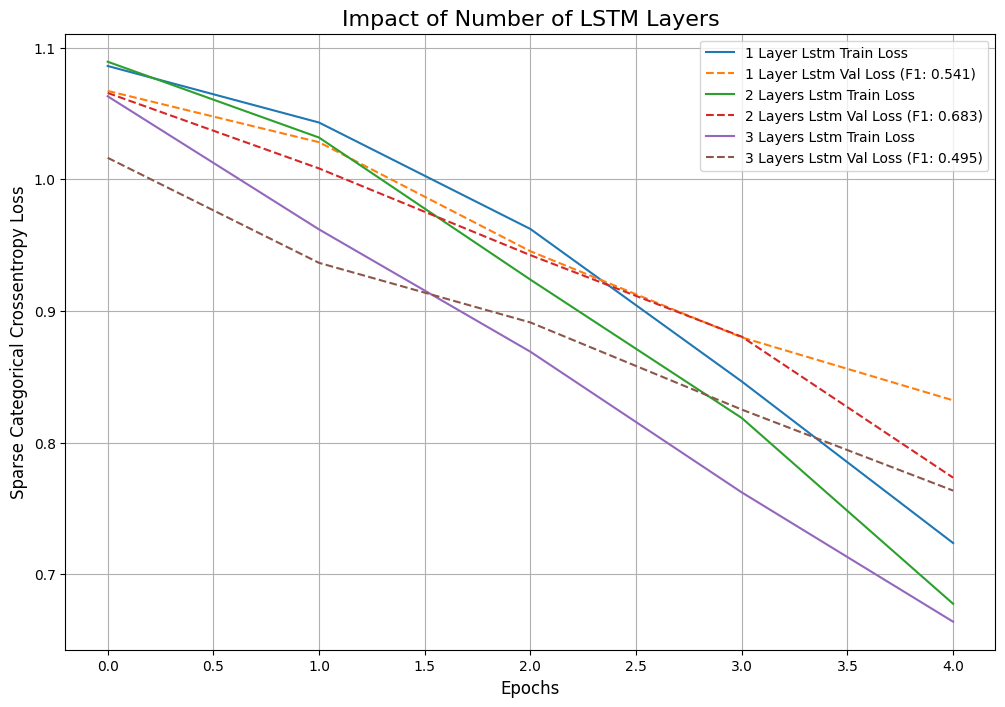


Number of LSTM Layers F1 Score Summary
2 Layers Lstm: 0.6825
1 Layer Lstm: 0.5409
3 Layers Lstm: 0.4954


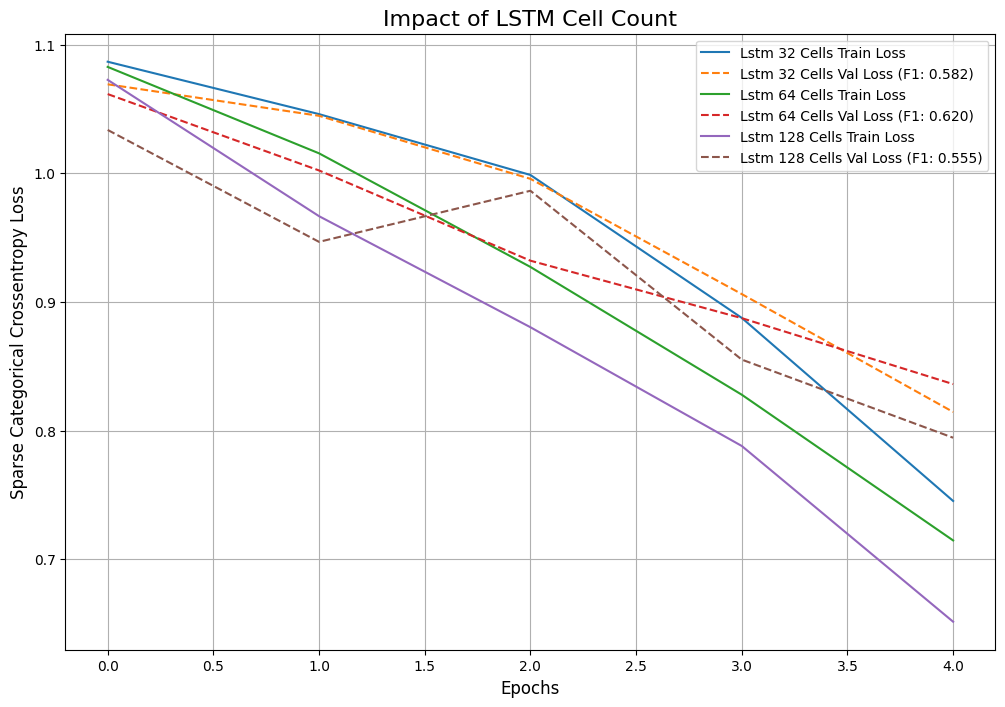


LSTM Cell Count F1 Score Summary
Lstm 64 Cells: 0.6202
Lstm 32 Cells: 0.5815
Lstm 128 Cells: 0.5545


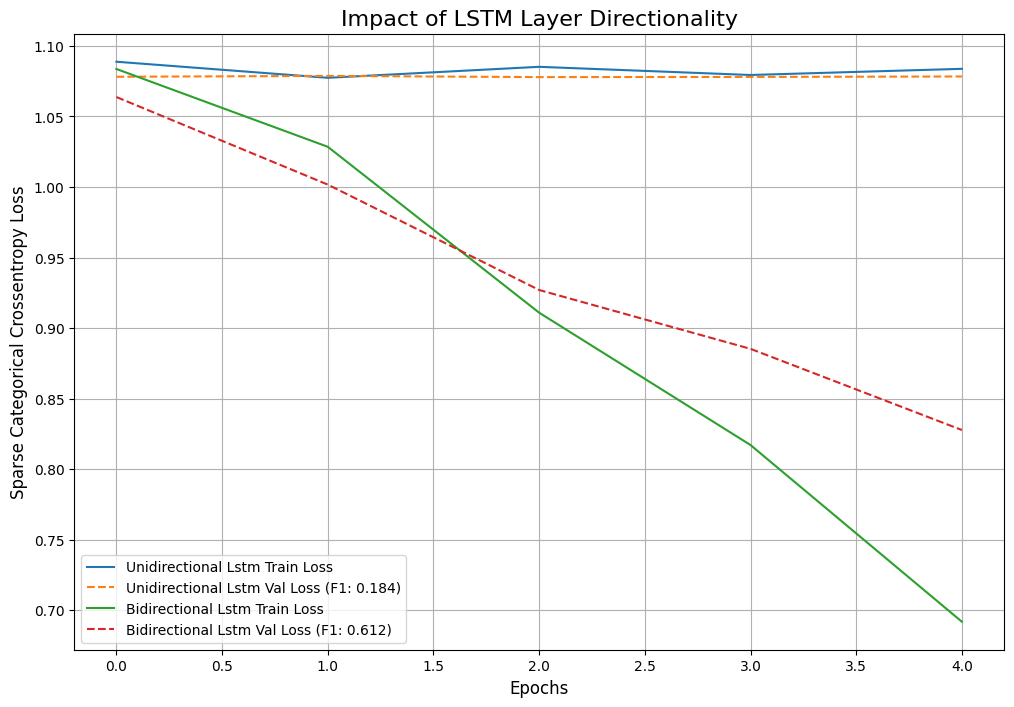


LSTM Layer Directionality F1 Score Summary
Bidirectional Lstm: 0.6118
Unidirectional Lstm: 0.1844


In [7]:
plot_loss_curves(all_results['num_layers'], 'Impact of Number of LSTM Layers')
print_f1_summary(all_results['num_layers'], 'Number of LSTM Layers')

plot_loss_curves(all_results['cell_count'], 'Impact of LSTM Cell Count')
print_f1_summary(all_results['cell_count'], 'LSTM Cell Count')

plot_loss_curves(all_results['direction'], 'Impact of LSTM Layer Directionality')
print_f1_summary(all_results['direction'], 'LSTM Layer Directionality')

# Compare Forward Pass

In [9]:
BATCH_SIZE = 32

train_ds, val_ds, _, _, NUM_CLASSES, (X_test, y_test) = prepare_data(
    max_vocab_size=15000, 
    max_sequence_length=250,
    batch_size=BATCH_SIZE
)

# Keras
MODEL_NAME = 'test_lstm_forward_pass'
MODEL_CONFIG = [('bidirectional', 64), ('unidirectional', 128)]

print(f"Building Keras model '{MODEL_NAME}'...")
keras_model = build_keras_lstm_model(
    num_classes=NUM_CLASSES,
    vocab_size=15000,
    emb_dim=128,
    seq_len=250,
    lstm_layers_config=MODEL_CONFIG
)

train_model(keras_model, train_ds, val_ds, 10, MODEL_NAME)

Loading data from https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/
Data loaded successfully.
Building Keras model 'test_lstm_forward_pass'...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.3877 - loss: 1.0903 - val_accuracy: 0.3800 - val_loss: 1.0884
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.3425 - loss: 1.0983 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.4260 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.3627 - loss: 1.0872 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.3754 - loss: 1.0804 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.3855 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - a

{'history': {'accuracy': [0.39800000190734863,
   0.3540000021457672,
   0.3799999952316284,
   0.37400001287460327,
   0.38199999928474426,
   0.38199999928474426,
   0.38199999928474426,
   0.3319999873638153,
   0.3700000047683716,
   0.37599998712539673],
  'loss': [1.085204839706421,
   1.0891159772872925,
   1.0823315382003784,
   1.0852631330490112,
   1.0773510932922363,
   1.0782746076583862,
   1.0798531770706177,
   1.0839266777038574,
   1.0801090002059937,
   1.0779321193695068],
  'val_accuracy': [0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284,
   0.3799999952316284],
  'val_loss': [1.0884469747543335,
   1.0784595012664795,
   1.0786951780319214,
   1.0782804489135742,
   1.0780260562896729,
   1.0781184434890747,
   1.0788309574127197,
   1.0781458616256714,
   1.0781916379928589,
   1.0781447887420654]},
 'model': <

In [11]:
try:
    keras_model.load_weights(f'models/{MODEL_NAME}.weights.h5')
except FileNotFoundError:
    print(f"Weight file '{MODEL_NAME}.weights.h5' not found. Please run train.py first.")

print(f"Performing prediction with Keras (Batch Size: {BATCH_SIZE})...")
keras_probs = keras_model.predict(X_test, batch_size=BATCH_SIZE)
keras_preds = np.argmax(keras_probs, axis=1)
keras_f1 = f1_score(y_test, keras_preds, average='macro')
keras_acc = accuracy_score(y_test, keras_preds)

print(f"Keras Macro F1-Score: {keras_f1:.6f}")
print(f"Keras Accuracy: {keras_acc:.6f}")

# From scratch
print("\nBuilding and performing prediction with from-scratch model")
print(f"Batch size: {BATCH_SIZE}")

scratch_model = NumpyLSTM(keras_model)
scratch_preds = scratch_model.predict(X_test, batch_size=BATCH_SIZE)

scratch_f1 = f1_score(y_test, scratch_preds, average='macro')
scratch_acc = accuracy_score(y_test, scratch_preds)

print(f"From-Scratch Macro F1-Score: {scratch_f1:.6f}")
print(f"From-Scratch Accuracy: {scratch_acc:.6f}")

# Comparison
print("\nComparison Summary")
np.testing.assert_allclose(keras_f1, scratch_f1, rtol=1e-5, atol=1e-5)
print("Macro F1-Scores are approximately equal.")

if np.array_equal(keras_preds, scratch_preds):
    print("Predictions are identical.")
else:
    diff_count = np.sum(keras_preds != scratch_preds)
    total_count = len(y_test)
    print(f"Predictions have {diff_count} differences out of {total_count} samples ({diff_count/total_count:.4%} difference).")

Performing prediction with Keras (Batch Size: 32)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Keras Macro F1-Score: 0.184448
Keras Accuracy: 0.382500

Building and performing prediction with from-scratch model
Batch size: 32
From-Scratch Macro F1-Score: 0.184448
From-Scratch Accuracy: 0.382500

Comparison Summary
Macro F1-Scores are approximately equal.
Predictions are identical.
